In [5]:
#import graphlab as gl
import pandas as pd
import numpy as np
import cPickle
from matplotlib import pyplot as plt
%matplotlib inline
from seaborn import color_palette
from scipy.ndimage.filters import gaussian_filter1d
import bokeh
from bokeh.plotting import figure, output_file, show, curdoc
from bokeh.charts import Line
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import Circle,BoxSelectTool, BoxZoomTool, LassoSelectTool,Text,HoverTool,ColumnDataSource, Range1d, Axis

from bokeh.resources import CDN
#from bokeh.client import push_session
from bokeh.embed import file_html
from dateutil.parser import parse
from ipywidgets import interact,Checkbox,Select,HBox,Label,interactive,Text


bokeh.plotting.reset_output()
output_notebook()


Loading BokehJS ...

In [2]:
#df = pd.read_pickle('../data/genre-emergence.pkl')
#df['scrobble_time'] = df['scrobble_time'].apply(lambda x: pd.to_datetime(x))
#df.to_pickle('../data/genre-emergence.pkl')
df = pd.read_pickle('../data/genre-emergence.pkl')
genres = cPickle.load(open('../data/gn_genres.pkl'))



In [3]:
df.head()

,scrobble_time,genre1,genre2,genre3,count
0,2007-10-26,alternative & punk,alternative,alternative rock,62002
1,2010-07-09,alternative & punk,alternative,alternative rock,72834
2,2007-10-02,alternative & punk,alternative,alternative rock,62841
3,2007-01-24,alternative & punk,alternative,alternative rock,45484
4,2011-04-06,alternative & punk,alternative,alternative rock,85197


In [64]:
g1 = df.groupby(['scrobble_time','genre1'])['count'].sum().unstack()[genres['genre1']]
g2 = df.groupby(['scrobble_time','genre2'])['count'].sum().unstack()[map(lambda x: x.decode('utf-8'),genres['genre2'])]
g3 = df.groupby(['scrobble_time','genre3'])['count'].sum().unstack()[map(lambda x: x.decode('utf-8'),genres['genre3'])]

In [65]:
# gn=pd.read_table('/Users/jaredlorince/Dropbox/Research/misc.data/gracenote_song_data')
# genre_hierarchy = gn[['genre1','genre2','genre3']].drop_duplicates()
# genre_hierarchy.to_pickle('../genre_hierarchy.pkl')
genre_hierarchy = pd.read_pickle('../genre_hierarchy.pkl').dropna()
genre_hierarchy['genre2'] = genre_hierarchy['genre2'].apply(lambda x: x.decode('utf-8'))
genre_hierarchy['genre3'] = genre_hierarchy['genre3'].apply(lambda x: x.decode('utf-8'))

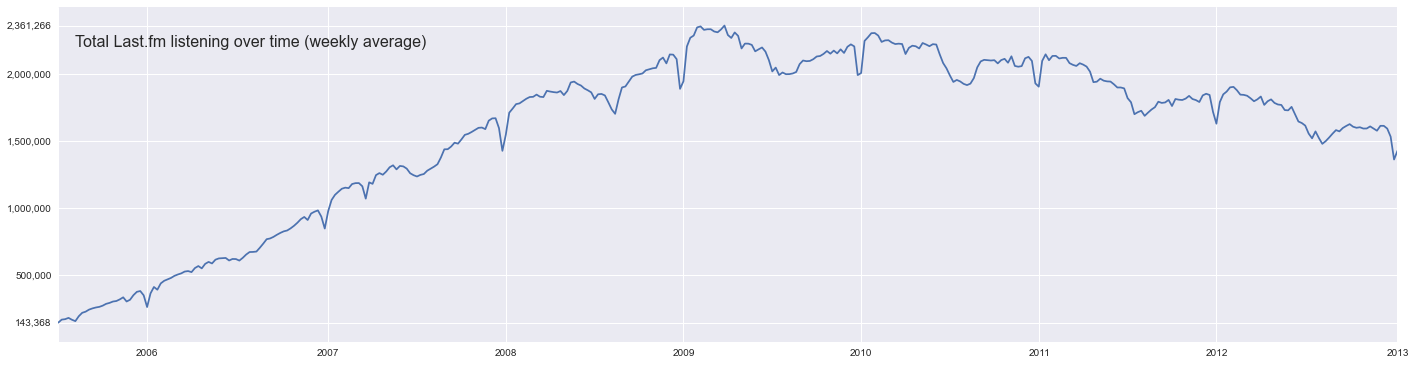

In [66]:
fig,ax = plt.subplots(1,1,figsize=(24,6))
plt_data = g1.sum(1).resample('W').mean()
plt_data.plot(figsize=(24,6),ax=ax)
ax.set_yticks([plt_data.min()]+list(np.arange(500000,2000001,500000))+[plt_data.max()])
ax.set_yticklabels(["{:,}".format(x) for x in [plt_data.min()]+list(np.arange(500000,2000001,500000))+[plt_data.max()]]);
ax.annotate("Total Last.fm listening over time (weekly average)",xy=('2005-08-01',2200000),fontsize=16) #\n(rolling proportion of never-\nbefore-listened artists, 100-\nlisten window)
ax.set_xlabel('');



In [14]:
totals = g1.sum(1)
cum_totals = g1.sum(1).cumsum()


NameError: name 'g1' is not defined

In [327]:
#bokeh.plotting.reset_output()
#output_file()


n = len(g1.columns)
p = figure(width=800,height=350,x_axis_type='datetime',tools=['pan,box_zoom,reset'])
colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("coolwarm",n_colors=n))).astype(int)]
p.select(dict(type=Axis, layout="left"))[0].formatter.use_scientific = False
idx = pd.date_range('2005-07-01','2012-12-31',freq='W')
datestrings = idx.map(lambda x: x.strftime('%Y-%m-%d'))
lines = {}
hovers = {}
data = {}
basedata = g1.resample('W').mean() 
for i,g in enumerate(sorted(g1.columns)):
    current = basedata[g]
    values=current
    totals_current = totals.resample('W').mean()
    cum_totals_current = cum_totals.resample('W').mean()
    data[g] = ColumnDataSource({'x':idx,'value':current,'date':datestrings,'percent':["{:,.0f}".format(x) for x in values]})
    lines[g] = p.line('x','value',source=data[g],color=colors[i],name=g,line_width=2)
    hovers[g] = HoverTool(renderers=[lines[g]],tooltips=[('genre', g),('date','@date'),('Mean listening this period','@percent')])
    p.add_tools(hovers[g])


def update(rawcount=True,cumulative=False,resample='W'):
    basedata = g1.resample(resample).mean() 
    if resample in ('M','A'):
        freq = resample+'S'
    else:
        freq = resample
    for g in g1.columns:
        idx = pd.date_range('2005-07-01','2012-12-31',freq=freq)
        datestrings = idx.map(lambda x: x.strftime('%Y-%m-%d'))
        current = basedata[g]
        totals_current = totals.resample(resample).mean()
        cum_totals_current = cum_totals.resample(resample).mean()
        if cumulative:
            if rawcount:
                values = current.cumsum()
            else:
                values = current.cumsum()/cum_totals_current
        else:
            if rawcount:
                values = current
            else:
                values = current/totals_current
        data[g].data['x'] = idx
        data[g].data['date'] = datestrings
        data[g].data['value'] = values
        data[g].data['percent'] = {False:values.apply(lambda x: "{:.2f}%".format(100*x)),True:["{:,.0f}".format(x) for x in values]}[rawcount]

    push_notebook()




In [328]:
show(p,notebook_handle=True);


In [232]:
interact(update,resample=['D','W','M',"A"]);#,rawcount=[False,True])#,cumulative=True)


In [364]:
#bokeh.plotting.reset_output()
#output_file()
output_notebook()

root_level = 2
root_genre = 'contemporary r&b/soul'
percentage_of_root_genre = True
rawcount = False
cumulative = False
child = False
resample = 'W'


def update(mode,genre=None,subgenre=None,rawcount=True,cumulative=False,resample='Weekly',child=False):
    
    p = figure(width=800,height=350,x_axis_type='datetime',tools=['pan,box_zoom,reset'])
    p.select(dict(type=Axis, layout="left"))[0].formatter.use_scientific = False
    print mode,genre,subgenre,rawcount,cumulative,resample
    #["View top-level genres","View sub-genres","View sub-sub-genres"]
    resample = {'Daily':'D','Weekly':'W','Monthly':'M','Yearly':'A'}[resample]
    freq = {'D':'D','W':'W','M':'MS','A':'AS'}[resample]
    if mode == "View top-level genres":
        basedata = g1.resample(resample).mean()
        genres = sorted(g1.columns)
    elif mode == "View sub-genres":
        basedata = g2.resample(resample).mean()
        parent_data = g1[genre].resample(resample).mean()
        genres = sorted(genre_hierarchy[genre_hierarchy['genre1']==genre]['genre2'].unique())

    elif mode == "View sub-sub-genres":
        basedata = g3.resample(resample).mean()
        parent_data = g2[subgenre].resample(resample).mean()
        genres = sorted(genre_hierarchy[genre_hierarchy['genre2']==subgenre]['genre3'].unique())
    
    lines = {}
    hovers = {}
    data = {}
    colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("coolwarm",n_colors=len(genres)))).astype(int)]
    idx = pd.date_range('2005-07-01','2012-12-31',freq=freq)
    datestrings = idx.map(lambda x: x.strftime('%Y-%m-%d'))
    for i,g in enumerate(genres):

        current = basedata[g]
        totals_current = totals.resample(resample).mean()
        #cum_totals_current = cum_totals.resample(resample).mean()
        if cumulative:
            if child:
                cum_totals_current = parent_data.cumsum()
            else:
                cum_totals_current = cum_totals.resample(resample).mean()
            if rawcount:
                values = current.cumsum()
            else:
                values = current.cumsum()/cum_totals_current
        else:
            if child:
                totals_current = parent_data
            else:
                totals_current = totals.resample(resample).mean()
            if rawcount:
                values = current
            else:
                values = current/totals_current
        
        data[g] = ColumnDataSource({'x':idx,'value':values,'date':datestrings,'percent':{False:values.apply(lambda x: "{:.2f}%".format(100*x)),True:["{:,.0f}".format(x) for x in values]}[rawcount]})
        lines[g] = p.line('x','value',source=data[g],color=colors[i],name=g,line_width=2)
        hovers[g] = HoverTool(renderers=[lines[g]],tooltips=[('genre', g),('date','@date'),('Mean listening this period','@percent')])
        p.add_tools(hovers[g])
    show(p)




Loading BokehJS ...

In [366]:
from ipywidgets import interact,Checkbox,Select,HBox,Label,interactive,VBox,Box

level_select = Dropdown(options=["View top-level genres","View sub-genres","View sub-sub-genres"])
genre_select = Dropdown(options=['n/a'])
subgenre_select = Dropdown(options=['n/a'])
rawcount_select = Checkbox(description = 'rawcount',value=True)
cumulative_select = Checkbox(description='cumulativ',value=False)
resample_select = Dropdown(description="Resample",options=["Daily","Weekly","Monthly","Yearly"],value="Weekly")
child_select = Checkbox(description='% of parent',value=False,disabled=True)

def update_genre_select(*args):
    if level_select.value == 'View top-level genres':
        genre_select.options = ['n/a']
        genre_select.value = 'n/a'
        subgenre_select.options = ['n/a']
        subgenre_select.value = 'n/a'
        child_select.disabled = True
    elif level_select.value == "View sub-genres":
        genre_select.options = sorted(genre_hierarchy['genre1'].unique())
        subgenre_select.options = ['n/a']
        subgenre_select.value = 'n/a'
        child_select.disabled = False
    elif level_select.value == "View sub-sub-genres":
        subgenre_select.options = sorted(genre_hierarchy[genre_hierarchy['genre1']==genre_select.value]['genre2'].unique())
        child_select.disabled = False

def update_subgenre_select(*arg):
    if level_select.value == "View sub-sub-genres":
        subgenre_select.options = sorted(genre_hierarchy[genre_hierarchy['genre1']==genre_select.value]['genre2'].unique())
    

        
level_select.observe(update_genre_select, 'value')
genre_select.observe(update_subgenre_select,'value')


interact(update,rawcount=rawcount_select,cumulative=cumulative_select,
         mode=level_select,genre=genre_select,subgenre=subgenre_select,
         child=child_select,resample=resample_select);


View top-level genres n/a n/a False False Weekly


In [9]:
#df_artists = pd.read_pickle('/Users/jaredlorince/Desktop/artist-consumption.pkl')
#df_artists['scrobble_time'] = df_artists['scrobble_time'].apply(lambda x: pd.to_datetime(x))
#df_artists.to_pickle('/Users/jaredlorince/Desktop/artist-consumption.pkl')
df_artists = pd.read_pickle('/Users/jaredlorince/Desktop/artist-consumption-ts.pkl')

In [10]:
artist_dict = {}
with open('/Users/jaredlorince/git/MusicForaging/GenreModeling/data/artist_ids') as f:
    for line in f:
        line = line.strip().split('\t')
        #artist_dict[int(line[0])] = line[1]
        artist_dict[line[1]] = int(line[0])
        

In [12]:
output_notebook()


def update(rawcount=True,cumulative=False,resample='Weekly',artists='the+beatles'):
    artists = dict(zip([artist_dict[a] for a in artists.split()],artists.split()))
    p = figure(width=800,height=350,x_axis_type='datetime',tools=['pan,box_zoom,reset'])
    p.select(dict(type=Axis, layout="left"))[0].formatter.use_scientific = False
    #["View top-level genres","View sub-genres","View sub-sub-genres"]
    resample = {'Daily':'D','Weekly':'W','Monthly':'M','Yearly':'A'}[resample]
    freq = {'D':'D','W':'W','M':'MS','A':'AS'}[resample]
    idx = pd.date_range('2005-07-01','2012-12-31',freq=freq)
    datestrings = idx.map(lambda x: x.strftime('%Y-%m-%d'))

    lines = {}
    hovers = {}
    data = {}
    colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("coolwarm",n_colors=len(genres)))).astype(int)]
    for i,artist in enumerate(artists):
        current = df_artists[df_artists['artist_id']==artist].set_index('scrobble_time')['count'].resample(resample).mean()
        totals_current = totals.resample(resample).mean()

        if cumulative:
            cum_totals_current = cum_totals.resample(resample).mean()
            if rawcount:
                values = current.cumsum()
            else:
                values = current.cumsum()/cum_totals_current
        else:
            totals_current = totals.resample(resample).mean()
            if rawcount:
                values = current
            else:
                values = current/totals_current
        data[artist] = ColumnDataSource({'x':idx,'value':values,'date':datestrings,'percent':{False:values.apply(lambda x: "{:.2f}%".format(100*x)),True:values.apply(lambda x: "{:,.0f}".format(x))}[rawcount]})
        lines[artist] = p.line('x','value',source=data[artist],color=colors[i],name=g,line_width=2)
        hovers[artist] = HoverTool(renderers=[lines[artist]],tooltips=[('artist', artists[artist]),('date','@date'),('Mean listening this period','@percent')])
        p.add_tools(hovers[artist])
    show(p)
    




Loading BokehJS ...

In [ ]:
show(p,notebook_handle=True);


In [13]:
from ipywidgets import Dropdown

artist_select = Text(value='the+beatles')
rawcount_select = Checkbox(description = 'rawcount',value=True)
cumulative_select = Checkbox(description='cumulativ',value=False)
resample_select = Dropdown(description="Resample",options=["Daily","Weekly","Monthly","Yearly"],value="Weekly")


interact(update,rawcount=rawcount_select,cumulative=cumulative_select,
         artist=artist_select,resample=resample_select);


NameError: global name 'totals' is not defined

In [445]:
artist = 1996
current = df_artists[df_artists['artist_id']==artist].set_index('scrobble_time')['count'].resample(resample).mean()
current.iloc[0]

796.33333333333337